In [91]:
!pip3 install -qU boto3 
!pip3 install -qU Pillow

In [95]:
import json
import os
import glob
import sys
import boto3
import base64
import requests
import time
import pprint
from datetime import datetime
from IPython.display import Image, display

In [ ]:
#get modelARN
region = 'us-east-1'#'us-west-2' #
boto3_bedrock = boto3.client('bedrock',region)
boto3_bedrock.list_foundation_models()

In [ ]:
!wget https://cats.com/wp-content/uploads/2020/10/tabby-maine-coon-768x384.jpg

In [ ]:
stream = False
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [ ]:
#"modelId": "anthropic.claude-3-sonnet-20240229-v1:0"
# non streaming mode
def anthropic_claude_3(modelId,image_path,max_tokens,system_prompt):
    bedrock_runtime = boto3.client('bedrock-runtime')
    base64_image = encode_image(image_path)
    payload = {
        "modelId": modelId,
        "contentType": "application/json",
        "accept": "application/json",
        "body": {
            "anthropic_version": "bedrock-2023-05-31",
            "system": system_prompt,
            "max_tokens": max_tokens,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/png",
                                "data": base64_image
                            }
                        },
                        {
                            "type": "text",
                            #"text": "Write me a detailed description of these two photos, and then a poem talking about it."
                            "text": f"这是我审查的结果："
                        }
                    ]
                }
            ]
        }
    }
	
    # Convert the payload to bytes
    body_bytes = json.dumps(payload['body']).encode('utf-8')
	
    # Invoke the model
    response = bedrock_runtime.invoke_model(
        body=body_bytes,
        contentType=payload['contentType'],
        accept=payload['accept'],
        modelId=payload['modelId']
    )
	
    # Process the response
    response_body = json.loads(response['body'].read().decode('utf-8'))
    pprint.pprint(response_body)
    #return round(end-start,2),response_body["usage"]["input_tokens"],response_body["usage"]["output_tokens"]
    return round(float(response['ResponseMetadata']['HTTPHeaders']['x-amzn-bedrock-invocation-latency'])/1000,2),int(response['ResponseMetadata']['HTTPHeaders']['x-amzn-bedrock-input-token-count']),int(response['ResponseMetadata']['HTTPHeaders']['x-amzn-bedrock-output-token-count'])
	

In [ ]:
#"modelId": "anthropic.claude-3-sonnet-20240229-v1:0"
# streaming mode
def anthropic_claude_3_stream(modelId,image_path,max_tokens,system_prompt):
    bedrock_runtime = boto3.client('bedrock-runtime')
    base64_image = encode_image(image_path)
    payload = {
        "modelId": modelId,
        "contentType": "application/json",
        "accept": "application/json",
        "body": {
            "anthropic_version": "bedrock-2023-05-31",
            "system": system_prompt,
            "max_tokens": max_tokens,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/png",
                                "data": base64_image
                            }
                        },
                        {
                            "type": "text",
                            #"text": "Write me a detailed description of these two photos, and then a poem talking about it."
                            "text": f"这是我审查的结果："
                        }
                    ]
                }
            ],
            "temperature": 1,
            "top_p": 0.999,
            "top_k": 250,
"stop_sequences": ['\n\nHuman:']
        }
    }
	
    # Convert the payload to bytes
    body_bytes = json.dumps(payload['body']).encode('utf-8')
	
    # Invoke the model
    response = bedrock_runtime.invoke_model_with_response_stream(
        body=body_bytes, modelId=payload['modelId'], accept=payload['accept'], contentType=payload['contentType']
    )
    stream = response.get('body')
    chunk_obj = {}
	
    if stream:
        for event in stream:
            chunk = event.get('chunk')
            if chunk:
                chunk_obj = json.loads(chunk.get('bytes').decode())
                pprint.pprint(chunk_obj)
	
    # Process the response
    #response_body = json.loads(response['body'].read().decode('utf-8'))
    #pprint.pprint(response_body)
    {'type': 'message_stop', 'amazon-bedrock-invocationMetrics': {'inputTokenCount': 92, 'outputTokenCount': 277, 'invocationLatency': 3679, 'firstByteLatency': 677}}
	
    return round(float(chunk_obj['amazon-bedrock-invocationMetrics']['firstByteLatency'])/1000,2),round(float(chunk_obj['amazon-bedrock-invocationMetrics']['invocationLatency'])/1000,2),chunk_obj['amazon-bedrock-invocationMetrics']['inputTokenCount'],chunk_obj['amazon-bedrock-invocationMetrics']['outputTokenCount']

In [83]:
# 调用结果
image_path = "tabby-maine-coon-768x384.jpg"
max_tokens = 200
system = """你是一个图片审核的AI专家，你需要协助人类进行图片审核的工作，你审核图片的标准如下
1. 图片需要是真人，女生，五官清晰，五官端正，图片包含有完整的脸部内容，
2. 图片不能够只露出眼睛，不能带面罩和口罩
2. 图片不能是动漫风格、不能男女混合（不能出现男性）、不能出现小孩、不能是纯风景
3. 图片不能太小，也就是图片的分辨率要高，同时尺寸不能小于480*768
4. 图片除非裸露了胸部和下体才可以判定为不通过，如果只是露出肩膀，露出肚脐，露出大腿和小腿这些都属于可以判定为通过，也就是整体构图不露骨就可以通过
5. 图片严禁涉及血腥、政治的题材，但是如果只是穿着和宗教风俗有关的衣服，其他方面没有问题，应该判为通过
你的输出请按照下面的json格式给出,如果不通过，请给出原因:
{ "结果" = "通过" or "不通过",
  "图片描述" = "xxxxxx",
  "不通过的原因" = "xxxx"
}
"""

In [ ]:
#haiku
print("Haiku:")
modelId = "anthropic.claude-3-haiku-20240307-v1:0"


In [ ]:
print(anthropic_claude_3(modelId,image_path,max_tokens,system))

In [ ]:
print(anthropic_claude_3_stream(modelId,image_path,max_tokens,system))	

In [74]:
#sonnet
print("Sonnet:")
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"


Sonnet:


In [ ]:
print(anthropic_claude_3(modelId,image_path,max_tokens,system))

In [ ]:
print(anthropic_claude_3_stream(modelId,image_path,max_tokens,system))		

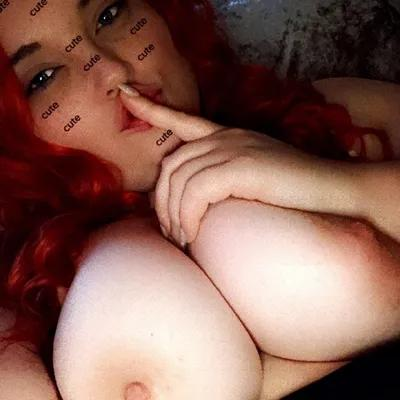

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片显示了一位裸露上身的成年女性,她有着红色的长发,双手支撑在下巴处。画面中出现了她的部分胸部。",\n'
                      '  "不通过的原因": '
                      '"根据您提供的审核标准,由于这张图片存在裸露人体的情况,因此被判定为不通过。虽然构图本身没有露骨内容,但是因为有裸露的部位,所以不符合要求。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_017yG7jV7oE3KJKmfwKMo95B',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 685, 'output_tokens': 166}}
(5.96, 685, 166)


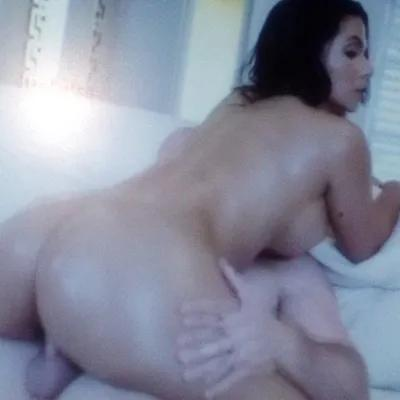

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "这张图片显示一名赤裸的女性正在私密场合摆出一个暴露的姿势。",\n'
                      '  "不通过的原因": '
                      '"这张图片涉及太多裸露成人内容,因此不符合您提供的审核标准。根据您的第4点要求,如果裸露了胸部和下体,应该判定为不通过。此外,此类露骨的成人内容也可能会对某些观众造成冒犯或不适。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_011eDybV5adGcVKyfeMB4AjJ',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 685, 'output_tokens': 168}}
(9.51, 685, 168)


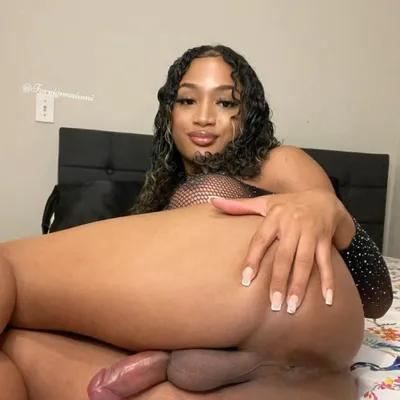

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片展示了一位年轻的非裔美国女性,她躺在沙发上,上身穿着一件黑色亮片上衣,下身赤裸,构图十分露骨。",\n'
                      '  "不通过的原因": '
                      '"该图片存在明确的性暴力内容,与您提供的审核标准不符,因此我无法通过审核。我理解这种类型的图片可能有一定的艺术表现力,但考虑到其公开传播的影响,建议符合道德操守的公众传播原则。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_018eZuwMmhvSajZBPzhHobbg',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 685, 'output_tokens': 191}}
(9.15, 685, 191)


In [97]:
# 指定你的图片目录路径
directory_path = '图片测试/Porn'
# 创建图片文件的完整路径模式
pattern = os.path.join(directory_path, '*.jpg')

# 使用glob找到所有的.jpg文件
image_files = glob.glob(pattern)

# 如果没有找到文件，打印消息
if not image_files:
    print("No defined pattern files found in the directory.")
else:
    # 打印每一个文件的路径
    for image_file in image_files:
        display(Image(filename=image_file))
        print(anthropic_claude_3(modelId,image_file,max_tokens,system))
